In [2]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import seaborn as sns
from datasets import *

%matplotlib inline


import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split


warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 40)
random_state = 20180415

#### Importing graduation rates

In [3]:
excel_file = 'graduation_rates_public_school_2010_2011.xlsx'
df1 = pd.read_excel(excel_file,sheet_name=0)

#### Importing school progress reports and class size stats

In [4]:
df2 = pd.read_csv('2019_2010_schools_progress.csv')
classsize = pd.read_csv('class_size.csv')
SAT_df=pd.read_csv('https://data.cityofnewyork.us/resource/rt5r-ie69.csv')
SAT_df = SAT_df.rename(columns={'dbn':
                      'DBN'})

In [5]:
df2 = df2.dropna(subset=['2009-2010 OVERALL GRADE'])
overall_grades = ['overall_grade_' + grade for grade in df2['2009-2010 OVERALL GRADE'].unique()]
for grade in df2['2009-2010 OVERALL GRADE'].unique():
    df2['overall_grade_' + grade] = (df2['2009-2010 OVERALL GRADE']==grade)*1

df2 = df2.dropna(subset=['2009-2010 ENVIRONMENT GRADE'])
overall_grades = ['environment_grade_' + grade for grade in df2['2009-2010 ENVIRONMENT GRADE'].unique()]
for grade in df2['2009-2010 ENVIRONMENT GRADE'].unique():
    df2['environment_grade_' + grade] = (df2['2009-2010 ENVIRONMENT GRADE']==grade)*1

the_grade = '2009-2010 PERFORMANCE GRADE'
df2 = df2.dropna(subset=[the_grade])
overall_grades = ['performance_grade_' + grade for grade in df2[the_grade].unique()]
for grade in df2[the_grade].unique():
    df2['performance_grade_' + grade] = (df2[the_grade]==grade)*1

the_grade = '2009-2010 PROGRESS GRADE'
df2 = df2.dropna(subset=[the_grade])
overall_grades = ['progress_grade_' + grade for grade in df2[the_grade].unique()]
for grade in df2[the_grade].unique():
    df2['progress_grade_' + grade] = (df2[the_grade]==grade)*1



df2.columns


Index(['DBN', 'DISTRICT', 'SCHOOL', 'PRINCIPAL', 'PROGRESS REPORT TYPE',
       'SCHOOL LEVEL*', 'PEER INDEX*', '2009-2010 OVERALL GRADE',
       '2009-2010 OVERALL SCORE', '2009-2010 ENVIRONMENT CATEGORY SCORE',
       '2009-2010 ENVIRONMENT GRADE', '2009-2010 PERFORMANCE CATEGORY SCORE',
       '2009-2010 PERFORMANCE GRADE', '2009-2010 PROGRESS CATEGORY SCORE',
       '2009-2010 PROGRESS GRADE', '2009-2010 ADDITIONAL CREDIT',
       '2008-09 PROGRESS REPORT GRADE', 'overall_grade_C', 'overall_grade_A',
       'overall_grade_B', 'overall_grade_D', 'overall_grade_F',
       'environment_grade_B', 'environment_grade_A', 'environment_grade_C',
       'environment_grade_F', 'environment_grade_D', 'performance_grade_D',
       'performance_grade_C', 'performance_grade_A', 'performance_grade_F',
       'performance_grade_B', 'progress_grade_B', 'progress_grade_A',
       'progress_grade_D', 'progress_grade_F', 'progress_grade_C'],
      dtype='object')

#### Merging all datasets based on DBN (unique identifier for schools)

In [6]:
df3 = pd.merge(df1, df2, on='DBN')
df3 = pd.merge(df3, classsize, on='DBN')
df3 = pd.merge(df3, SAT_df, on='DBN')

In [7]:
df3.head()

,DBN,School Name,Category,Cohort Year,Cohort,Cohort Total,Grads Total,Grads Percent of Cohort,Regents Total,Regents Percent of Cohort,Regents Percent of Grads,Advanced Regents Total,Advanced Regents Percent of Cohort,Advanced Regents Percent of Grads,Regents without Advanced Total,Regent without Advanced Percent of Cohort,Regents without Advanced Percent of Grads,Local Total,Local Percent of Cohort,Local Percent of Grads,...,environment_grade_F,environment_grade_D,performance_grade_D,performance_grade_C,performance_grade_A,performance_grade_F,performance_grade_B,progress_grade_B,progress_grade_A,progress_grade_D,progress_grade_F,progress_grade_C,min,max,mean,critical_reading_mean,mathematics_mean,number_of_test_takers,school_name,writing_mean
0,01M292,Orchard Collegiate Academy,All Students,2011,4 year August,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
1,01M292,Orchard Collegiate Academy,All Students,2011,4 year August,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,0,1,1,0,0,0,0,0,0,0,0,1,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
2,01M292,Orchard Collegiate Academy,All Students,2010,4 year August,61,26,42.623,26,42.623,100,1,1.63934,3.84615,25,40.9836,96.1538,0,0,0,...,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
3,01M292,Orchard Collegiate Academy,All Students,2010,4 year August,61,26,42.623,26,42.623,100,1,1.63934,3.84615,25,40.9836,96.1538,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,1,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
4,01M292,Orchard Collegiate Academy,All Students,2011,4 year June,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0


#### Converting columns to numeric

In [8]:
cols = ['Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min']
df3[cols] = df3[cols].apply(pd.to_numeric,errors='coerce')
df3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3950 entries, 0 to 3949
Data columns (total 68 columns):
DBN                                          3950 non-null object
School Name                                  3950 non-null object
Category                                     3950 non-null object
Cohort Year                                  3950 non-null int64
Cohort                                       3950 non-null object
Cohort Total                                 3950 non-null int64
Grads Total                                  3950 non-null object
Grads Percent of Cohort                      3950 non-null object
Regents Total                                3950 non-null object
Regents Percent of Cohort                    3950 non-null float64
Regents Percent of Grads                     3950 non-null object
Advanced Regents Total                       3950 non-null object
Advanced Regents Percent of Cohort           3950 non-null float64
Advanced Regents Percent of Grads  

#### Choosing features and splitting data into trainingn, test and holdout

In [9]:
features = (['DISTRICT', 'PEER INDEX*', '2009-2010 ENVIRONMENT CATEGORY SCORE', '2009-2010 PERFORMANCE CATEGORY SCORE', '2009-2010 PROGRESS CATEGORY SCORE','Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min'])

##features = (['Grads Percent of Cohort'])

model_df = df3[(features + ['Grads Percent of Cohort'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['Grads Percent of Cohort'], test_size=0.1,
    random_state=random_state)

train_df['Grads Percent of Cohort'] = y_train
holdout_df['Grads Percent of Cohort'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df['Grads Percent of Cohort'].mean())
print(holdout_df.shape[0], holdout_df['Grads Percent of Cohort'].mean())





3555 74.33381395441786
395 73.77366342908861


In [10]:
model_df.shape

(3950, 14)

In [11]:
train_df.shape

(3555, 14)

In [12]:
holdout_df.shape
holdout_df

,index,DISTRICT,PEER INDEX*,2009-2010 ENVIRONMENT CATEGORY SCORE,2009-2010 PERFORMANCE CATEGORY SCORE,2009-2010 PROGRESS CATEGORY SCORE,Regents Percent of Cohort,Advanced Regents Percent of Cohort,Regent without Advanced Percent of Cohort,Dropout Percent of Cohort,mean,max,min,Grads Percent of Cohort
0,3092,23,2.24,9.6,18.8,25.8,16.666666,0.000000,16.666666,8.333333,16.640000,25.0,10.0,20.8333
1,2877,20,2.59,11.0,13.2,36.3,70.852432,23.739689,47.112740,16.223648,26.433333,34.0,5.0,74.7021
2,1328,9,2.29,7.3,12.6,37.2,70.873787,1.941748,68.932037,12.621359,21.138235,31.5,6.0,81.5534
3,2898,21,2.05,11.2,5.9,31.1,84.146339,0.000000,84.146339,13.414634,20.223077,23.5,15.2,84.1463
4,417,2,3.18,6.4,20.9,43.7,95.402298,34.482758,60.919540,1.149425,26.687500,34.0,14.0,95.977
5,3662,29,2.61,5.0,14.1,29.4,60.000000,0.000000,60.000000,7.777778,28.356522,34.0,15.0,64.4444
6,768,4,2.53,12.9,10.9,47.0,95.789474,27.368422,68.421051,2.105263,25.941935,33.0,17.0,96.8421
7,1581,10,2.39,8.4,22.5,44.0,66.942146,2.479339,64.462807,4.132231,27.813514,34.0,15.0,68.595
8,3570,28,2.59,8.3,15.2,32.0,68.888886,7.407407,61.481480,5.925926,28.315152,34.0,10.0,74.8148
9,2736,17,3.32,7.4,16.2,45.8,99.086761,32.876713,66.210045,0.913242,27.879167,35.7,19.5,99.0868


#### Linear Regression with Cross Validation

In [89]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [90]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'Grads Percent of Cohort'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = mean_squared_error(train_df.loc[test,'Grads Percent of Cohort'], y_predicted)
        results.append(accuracy)
        print(classifier.score(train_df.loc[train, features],train_df.loc[train, 'Grads Percent of Cohort']))
    
    return np.mean(results), np.std(results)

In [91]:
reg = LinearRegression()
get_cv_results(reg)


0.9435536695807089
0.9434424689716072
0.9433084781110792
0.9429266257910759
0.9433666255660863


(21.623949832401397, 0.9468176222447461)

#### Classification Overall Grade

In [56]:
features = (['DISTRICT', 'PEER INDEX*','environment_grade_B', 'environment_grade_A', 'environment_grade_C',
       'environment_grade_F', 'environment_grade_D', 'performance_grade_D',
       'performance_grade_C', 'performance_grade_A', 'performance_grade_F',
       'performance_grade_B', 'progress_grade_B', 'progress_grade_A',
       'progress_grade_D', 'progress_grade_F', 'progress_grade_C','Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min','Grads Percent of Cohort']
           )

model_df = df3[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

In [82]:
features = (['DISTRICT', 'Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min','Grads Percent of Cohort','critical_reading_mean', 'mathematics_mean','writing_mean']
           )

model_df = df3[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

## Using these features

In [13]:
features = (['DISTRICT', 'mean','Grads Percent of Cohort','critical_reading_mean', 'mathematics_mean','writing_mean']
           )

model_df = df3[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

In [14]:
k_fold = KFold(n_splits=5, random_state=random_state)


In [15]:
def get_class_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, '2009-2010 OVERALL GRADE'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, '2009-2010 OVERALL GRADE'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)

In [16]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_class_results(logreg)

(0.4447368421052631, 0.020580309186862884)

In [17]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=5
)

get_class_results(dtree)

(0.5473684210526315, 0.026097207879163357)

In [18]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_class_results(rforest)

(0.643859649122807, 0.019562255770383317)

In [19]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_class_results(gbm)

(0.841812865497076, 0.0182695898851618)

#### Learning Curves

In [20]:
hp_values = range(1,50, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_class_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

1 0.40964912280701754 0.021514587297248134
3 0.4657894736842104 0.025567663437075047
5 0.5374269005847954 0.0208526892744742
7 0.638888888888889 0.01058301817008999
9 0.7172514619883041 0.023200975935529104
11 0.7798245614035088 0.01810978078035321
13 0.8289473684210525 0.02092227347368225
15 0.835672514619883 0.014869218871451609
17 0.8327485380116959 0.020396701785491574
19 0.8321637426900585 0.020139386383301223
21 0.8318713450292398 0.018071973263581786
23 0.8309941520467836 0.018297646604867854
25 0.8318713450292398 0.017347832718352427
27 0.8318713450292398 0.017347832718352427
29 0.8318713450292398 0.017347832718352427
31 0.8318713450292398 0.017347832718352427
33 0.8318713450292398 0.017347832718352427
35 0.8318713450292398 0.017347832718352427
37 0.8318713450292398 0.017347832718352427
39 0.8318713450292398 0.017347832718352427
41 0.8318713450292398 0.017347832718352427
43 0.8318713450292398 0.017347832718352427
45 0.8318713450292398 0.017347832718352427
47 0.8318713450292398 

Text(0.5, 0, 'Max Depth')

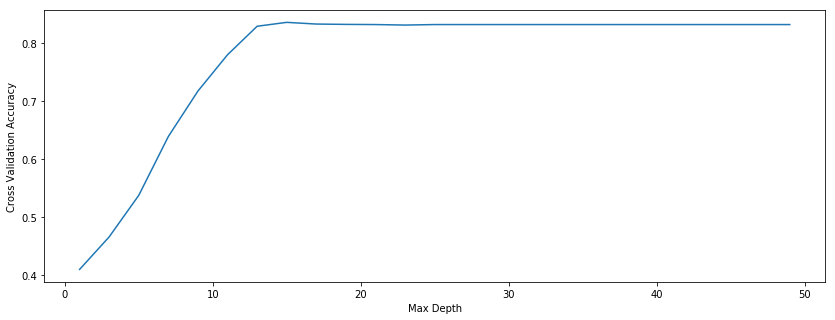

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

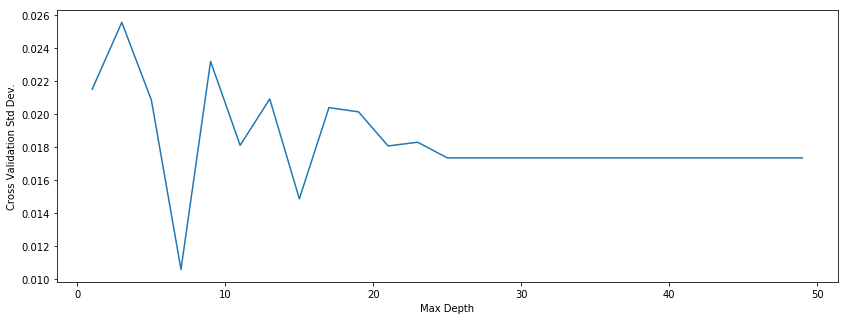

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev.')
plt.xlabel('Max Depth')

#### Model Performance